In [2]:
import pandas as pd
import os
import json
os.getcwd()

'/home/unix_jz/github/shade-calculator/dev'

In [55]:
log_path = "../../../naturalmaps_logs/overpass_query_log.json"
# Read the JSON data into a Pandas DataFrame
df = pd.read_json(log_path)
expanded_df = pd.json_normalize(df.T['log'])
log = expanded_df.set_index(df.columns)
log = log.dropna(how="all")
log['elements'] = log['overpass_response'].apply(lambda x: json.loads(x)["elements"] if isinstance(x, str) and "elements" in json.loads(x) else None)
log['elements'].fillna(log['response'].apply(lambda x: json.loads(x)["elements"] if isinstance(x, str) and "elements" in json.loads(x) else None), inplace=True)

log["returned_something"].fillna(log["elements"].apply(lambda x: (True if x and (len(x)>0) else False)), inplace=True)
log["overpass_response"].fillna(log["response"], inplace=True)
log["generated_oQL_query"].fillna(log["query"], inplace=True)
log["valid_query"].fillna(log["overpass_response"].apply(lambda x: (True if x and ("version") else False)), inplace=True)
log["temperature"].fillna(1, inplace=True)
log.drop(["response", "query", "query_success"], axis=1, inplace=True)
log = log.reindex(columns= ["temperature", "generated_oQL_query", "cleaned_oQL_query", "response", "overpass_response", "elements", "valid_query", "returned_something", "query_success"])
log.head()

,temperature,generated_oQL_query,cleaned_oQL_query,response,overpass_response,elements,valid_query,returned_something,query_success
2023-06-22 11:38:21 | Find all the ping pong tables in Berlin,1.0,[out:json];(node[leisure=table_tennis](around:...,NaN,NaN,"{""version"": 0.6, ""generator"": ""Overpass API 0....",[],True,False,NaN
2023-06-22 11:50:51 | Find all the ping pong tables in Monbijoupark,1.0,"[out:json];\nnode(52.5264,13.3996,52.5290,13.4...",NaN,NaN,"{""version"": 0.6, ""generator"": ""Overpass API 0....",[],True,False,NaN
2023-06-22 12:01:11 | Find all the ping pong tables in Monbijoupark,1.0,"[out:json];\narea[name=""Monbijoupark""]->.searc...",NaN,NaN,"{""version"": 0.6, ""generator"": ""Overpass API 0....",[],True,False,NaN
2023-06-22 12:36:38 | Find ping pong tables in Monbijoupark,1.0,"[out:json];\narea[name=""Berlin""][admin_level=2...",NaN,NaN,"{""version"": 0.6, ""generator"": ""Overpass API 0....",[],True,False,NaN
2023-06-22 12:36:40 | Find all the ping pong tables in Monbijoupark,1.0,"[out:json];\r\narea[name=""Monbijoupark""];\r\nn...",NaN,NaN,"{""version"": 0.6, ""generator"": ""Overpass API 0....",[],True,False,NaN


In [64]:
# Count the number of occurrences for each combination
grouped = log.groupby(['temperature', 'valid_query', 'returned_something']).size().reset_index(name='count')

# Calculate the total number of occurrences for each temperature
temperature_totals = grouped.groupby('temperature')['count'].sum().reset_index(name='total')

# Merge the total back to the grouped data
grouped = grouped.merge(temperature_totals, on='temperature')

# Calculate the percentages
grouped['valid_query_percentage'] = grouped.apply(lambda x: (x['count'] / x['total']) * 100 if x['valid_query'] else 0, axis=1)
grouped['returned_something_percentage'] = grouped.apply(lambda x: (x['count'] / x['total']) * 100 if x['returned_something'] else 0, axis=1)

# Pivot the data to create the summary table
summary = grouped.groupby('temperature').agg({
    'valid_query_percentage': 'sum',
    'returned_something_percentage': 'sum'
}).reset_index()

# Merge the total count into the summary table
summary = summary.merge(temperature_totals, on='temperature')
summary["valid_queries"] = (summary["valid_query_percentage"] * summary["total"] / 100).astype(int)
summary["returned_something"] = (summary["returned_something_percentage"] * summary["total"] / 100).astype(int)
summary

,temperature,valid_query_percentage,returned_something_percentage,total,valid_queries,returned_something
0,0.0,100.000000,59.493671,79,79,47
1,0.1,29.268293,2.439024,41,12,1
2,0.2,93.333333,34.166667,120,112,41
3,0.3,100.000000,0.000000,1,1,0
4,0.6,0.000000,0.000000,2,0,0
5,0.8,72.413793,3.448276,29,21,1
6,0.9,4.347826,0.000000,23,1,0
7,1.0,39.119171,22.020725,386,151,85
8,1.1,0.000000,0.000000,1,0,0
9,1.2,0.000000,0.000000,1,0,0


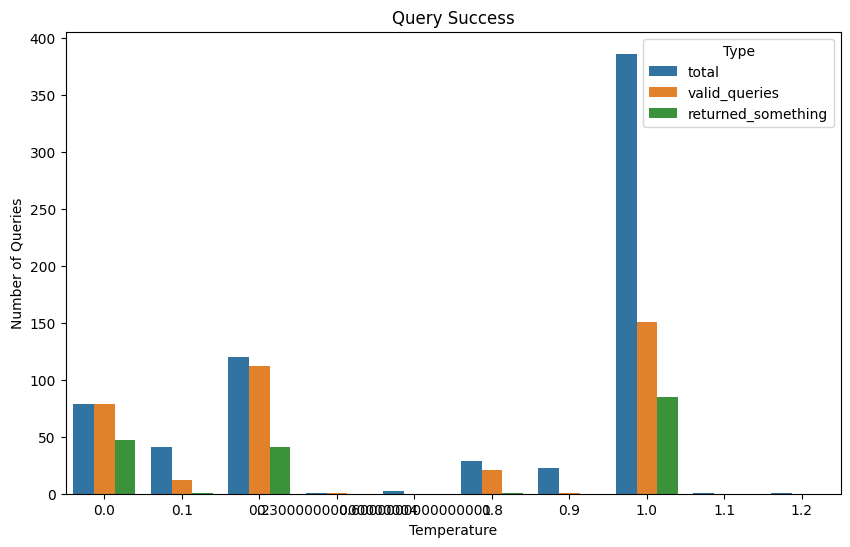

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
# Melt the data
melted_data = pd.melt(summary, id_vars=['temperature'], value_vars=['total', 'valid_queries', 'returned_something', ], 
                      var_name='Type', value_name='Count')

# Plot the data using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=melted_data, x='temperature', y='Count', hue='Type')
plt.xlabel('Temperature')
plt.ylabel('Number of Queries')
plt.title('Query Success')
plt.legend(title='Type')
plt.show()

In [53]:
json.loads("{\"version\": 0.6, \"generator\": \"Overpass API 0.7.60.6 e2dc3e5b\", \"osm3s\": {\"timestamp_osm_base\": \"2023-06-22T11:37:45Z\", \"copyright\": \"The data included in this document is from www.openstreetmap.org. The data is made available under ODbL.\"}, \"elements\": []}")

{'version': 0.6,
 'generator': 'Overpass API 0.7.60.6 e2dc3e5b',
 'osm3s': {'timestamp_osm_base': '2023-06-22T11:37:45Z',
  'copyright': 'The data included in this document is from www.openstreetmap.org. The data is made available under ODbL.'},
 'elements': []}